In [1]:
import wikipedia
import wikipediaapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Data Cleaning

In [2]:
## take all article in category (max_level control the depthness of articles taken from the subcategories)
def print_categorymembers(categorymembers, level=0, max_level=1):
    list_articles = []
    for c in categorymembers.values():
        if c.ns == 0:
            list_articles.append(c) 
            ##print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
        elif level < max_level and c.ns == 14:
            sub_list = []
            sub_list = print_categorymembers(c.categorymembers, level=level + 1, max_level=max_level)
            list_articles = list_articles + sub_list
    return list_articles

In [3]:
wiki_wiki = wikipediaapi.Wikipedia('en')
cat1 = wiki_wiki.page("Category:Religion")
cat2 = wiki_wiki.page("Category:Science")

In [4]:
religion_articles = print_categorymembers(cat1.categorymembers)
science_articles = print_categorymembers(cat2.categorymembers)

## This cell is about the hyperlink of articles but not relevant anymore

In [5]:
## Create the adjacency matrix
def make_links(list_articles):
    matrix = np.zeros((len(list_articles), len(list_articles)))
    compt = 0
    for article in list_articles:
        for link in article.links:
            for i in range(len(list_articles)):
                if (link == list_articles[i].title):
                    matrix[compt,i] = 1
    return matrix
adjacency_matrix = make_links(list_articles)
num_edges = np.count_nonzero(adjacency_matrix)
print(f"Number of edges in the feature graph: {num_edges}")

NameError: name 'list_articles' is not defined

In [6]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucaseckes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucaseckes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
#Take all the words present in the articles that are not stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop1 = ['====', '===', '==', '<<', '>>', "''", '``', "'s" , '\displaystyle', '...', '\phi', '\mu', '\mathbf', '--', 'x_',
        '\alpha', '\dot', '\hat', '\lambda', '\left', '\right', 'matcal', '\nu', '\partial']
stop2 = stopwords.words('english')
stop = stop1+stop2
wikipedia.set_lang('en')

def take_words(list_articles) :
    words_df = pd.DataFrame(columns=['article', 'words'])
    for i in range(len(list_articles)):
        if (i%10 == 0) :
            print(i)
        try: 
            page = wikipedia.page(list_articles[i].title)
        except wikipedia.DisambiguationError as e:
            s = e.options
            s = list(filter(lambda x : x != "", s))
            try :
                page = wikipedia.page(s)
            except wikipedia.DisambiguationError as e:
                pass
        except wikipedia.PageError:
            pass
        words = word_tokenize(page.content)
        words = [elem.lower() for elem in words]
        words = [elem for elem in words if len(elem) > 1 and elem.isdigit() == False]
        words_wostop = [x for x in words if x not in stop]
        words_wostop = [elem.lower() for elem in words_wostop]
        words_df.loc[i] = [list_articles[i].title] + [words_wostop]
    return words_df

In [8]:
religion_df = take_words(religion_articles)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380


/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790


In [9]:
science_df = take_words(science_articles)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650


In [10]:
words_df = pd.concat([religion_df, science_df])

In [33]:
TF_religion = religion_df.explode('words')
len_religion = len(TF_religion)
TF_science = science_df.explode('words')
len_science = len(TF_science)

In [34]:
TF_religion = TF_religion.groupby(['words']).count().reset_index().sort_values(['article'], ascending = False)
TF_religion['TF'] = TF_religion['article'].apply(lambda x : x/len_religion)
TF_science = TF_science.groupby(['words']).count().reset_index().sort_values(['article'], ascending = False)
TF_science['TF'] = TF_science['article'].apply(lambda x : x/len_science)

In [36]:
import math
IDF = words_df.explode('words').groupby(['words']).count().reset_index().sort_values(['article'], ascending = False)
IDF['IDF'] = IDF['article'].apply(lambda x : math.log(len(IDF)/x))
IDF

,words,article,IDF
104535,science,19668,1.905240
15880,also,15478,2.144813
85772,one,11955,2.403083
99572,religion,11045,2.482255
99653,religious,11021,2.484430
...,...,...,...
60372,identified.,1,11.791988
24674,bogost,1,11.791988
24675,bogota,1,11.791988
91628,plateau.women,1,11.791988


In [37]:
TF_IDF_religion = TF_religion.merge(IDF, on = ['words']).drop(['article_x', 'article_y'], axis = 1)
TF_IDF_religion['TF_IDF'] = TF_IDF_religion['TF']*TF_IDF_religion['IDF']
TF_IDF_science = TF_science.merge(IDF, on = ['words']).drop(['article_x', 'article_y'], axis = 1)
TF_IDF_science['TF_IDF'] = TF_IDF_science['TF']*TF_IDF_science['IDF']

In [42]:
important_words_df = pd.concat([TF_IDF_religion.sort_values(['TF_IDF'], ascending = False).head(500),TF_IDF_science.sort_values(['TF_IDF'], ascending = False).head(500)])

In [43]:
important_words_df = important_words_df.drop_duplicates(subset = ['words'])

In [45]:
important_words_df.sort_values(['TF_IDF'], ascending = False)

,words,TF,IDF,TF_IDF
0,religion,0.007073,2.482255,0.017558
1,religious,0.006923,2.484430,0.017199
3,god,0.004503,2.869997,0.012923
5,church,0.003775,3.084670,0.011643
2,scientific,0.004262,2.657773,0.011329
...,...,...,...,...
552,team,0.000292,5.304304,0.001548
529,shown,0.000300,5.163947,0.001548
606,persecution,0.000268,5.768540,0.001548
518,bodies,0.000303,5.103633,0.001546


In [46]:
explode_df = words_df.explode('words')
explode_df['exist'] = np.ones(len(explode_df))
df = pd.DataFrame(words_df['article']).assign(key = 1).merge(pd.DataFrame(important_words_df['words']).assign(key = 1), on = 'key').drop('key', 1)
df2 = df.merge(explode_df, on = ['article','words'] , how = 'left').drop_duplicates().fillna(0)
df3 = pd.pivot_table(df2, values = 'exist',  index = 'article', columns=['words'])
df3

words,ability,able,academic,academy,access,according,act,action,activities,acupuncture,...,worship,would,writing,written,wrote,year,years,yoga,york,young
article,,,,,,,,,,,,,,,,,,,,,
1888–1893 Uprisings of Hazaras,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2003 Quetta mosque bombing,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2004 Quetta Ashura massacre,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017–19 Iranian protests against compulsory hijab,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
2019 Indian Science Congress pseudoscience controversies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zero balancing,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Zmanim,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
Zoetron therapy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
features = df3.drop('article', axis = 1).values

In [48]:
np.sum(features, axis = 1)

array([110., 144.,  92., ...,  44., 155., 236.])

# Graph

In [49]:
distances = np.array([[(np.sum((features[i,:]-features[j,:])**2)) for i in range(0,features.shape[0]) ] for j in range(0,features.shape[0])]).reshape(features.shape[0],-1)

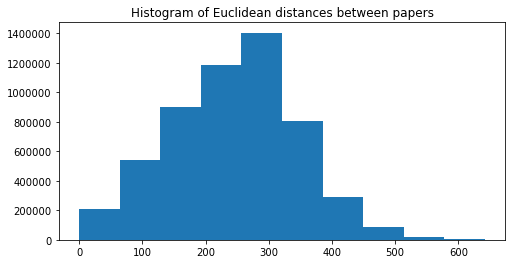

In [50]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distances.flatten());

In [51]:
feat = np.where(distances>150, 0, 1)
np.fill_diagonal(feat, 0)

In [52]:
graph = nx.from_numpy_matrix(feat)

In [ ]:
giant_feature = max(nx.connected_component_subgraphs(graph), key=len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

In [ ]:
nx.average_clustering(graph)

In [53]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    adjacency = squareform(pdist(X))
    adjacency = np.exp((- adjacency**2)/(2 * sigma**2))
    adjacency[adjacency < epsilon] = 0
    #according to the formula on slide 11 in the spectral clustering lecture, we set the diagonal to 0
    np.fill_diagonal(adjacency,0)
    return adjacency

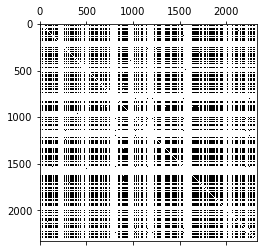

In [94]:
from scipy.spatial.distance import pdist, squareform
adjacency = epsilon_similarity_graph(feat, sigma= 5, epsilon=0.65)
plt.spy(adjacency)
plt.show()

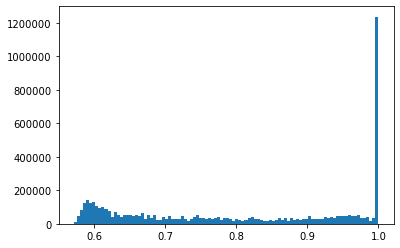

In [95]:
temp = np.exp((- squareform(pdist(feat))**2)/(2 * (1.5 * np.median(pdist(feat)))**2))
plt.hist(temp.flatten(),bins=100);

In [ ]:
import operator
pr = nx.pagerank(graph)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse = True)

In [ ]:
sorted_pr[:10]

In [ ]:
list_articles[794]

In [64]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    degrees_l = np.sum(adjacency,axis=1)
    if(not normalize):
        degrees = np.zeros(adjacency.shape)
        np.fill_diagonal(degrees,degrees_l)
        return degrees - adjacency 
    else:
        degrees = np.sqrt(np.array([degrees_l]).T @ np.array([degrees_l]))
        L = - adjacency/degrees
        np.fill_diagonal(L,np.ones(len(adjacency)))
        return L

In [65]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    values, vectors = np.linalg.eig(laplacian)
    sorted_indices = np.argsort(values)
    return values[sorted_indices], vectors[:,sorted_indices]
    # Your code here

In [96]:
laplacian = compute_laplacian(feat, normalize=True)
lam, U = spectral_decomposition(np.nan_to_num(laplacian))

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [67]:
def GFT(signal: np.ndarray):
    fourier = U.transpose()@signal
    return fourier

def iGFT(fourier_coefficients: np.ndarray):
    signal = U@fourier_coefficients
    return signal

In [97]:
alpha = 0.99 / np.max(lam)

ideal_tk =  1/(1 + alpha*lam)

In [69]:
def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
    """Return a filtered signal."""
    fourier = GFT(x);
    h = np.diag(spectral_response)
    filtered_graph = U@h@fourier
    return filtered_graph

In [98]:
x_tk = ideal_graph_filter(adjacency.tolist(),ideal_tk)

In [99]:
filt = np.where(x_tk>0.5, 1, 0)
np.fill_diagonal(filt, 0)

In [100]:
filt

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [101]:
graph_filt = nx.from_numpy_matrix(filt)

In [74]:
pr = nx.pagerank(graph_filt)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse = True)

KeyboardInterrupt: 

In [ ]:
sorted_pr[:10]

In [ ]:
list_articles[296]

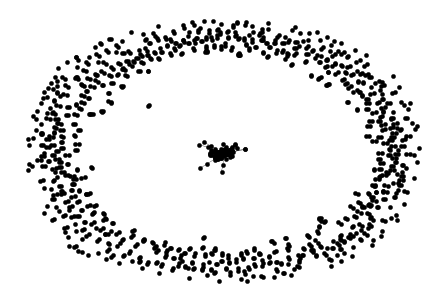

In [102]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(graph, **options)

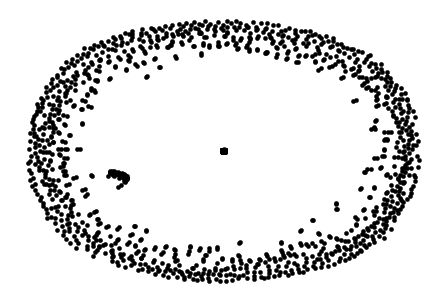

In [103]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(graph_filt, **options)

In [107]:
giant_features = max(nx.connected_component_subgraphs(graph_filt), key = len)

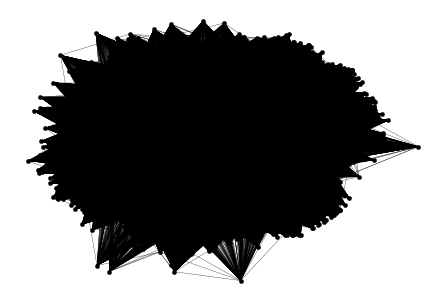

In [108]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(giant_features, **options)

In [110]:
giant_features.nodes

NodeView((2050, 3, 2051, 5, 7, 8, 9, 10, 11, 12, 13, 14, 2056, 2060, 2062, 18, 19, 20, 2063, 22, 2066, 24, 25, 26, 27, 2072, 2073, 2075, 2079, 32, 2080, 34, 35, 36, 2082, 38, 39, 2083, 41, 42, 43, 2091, 45, 2092, 47, 2094, 49, 50, 2096, 2098, 2099, 2100, 55, 56, 57, 58, 2101, 60, 61, 2102, 63, 64, 2104, 66, 2113, 68, 69, 70, 2115, 72, 2116, 74, 2118, 2121, 77, 2122, 79, 2123, 2125, 2127, 2128, 84, 2131, 86, 2132, 2133, 89, 90, 2136, 92, 93, 94, 95, 96, 97, 2137, 99, 2139, 101, 102, 103, 104, 2144, 2145, 107, 2147, 109, 110, 2153, 112, 2154, 2157, 115, 116, 117, 118, 2158, 120, 2160, 2161, 123, 124, 125, 126, 127, 128, 2168, 130, 131, 2172, 2174, 2175, 135, 136, 137, 2177, 139, 140, 2180, 142, 2187, 144, 145, 146, 2188, 2189, 2190, 2191, 151, 152, 2193, 154, 2194, 156, 2196, 158, 2198, 160, 2203, 2204, 2207, 164, 165, 2211, 2215, 169, 2218, 2221, 174, 175, 176, 2222, 2223, 2224, 2226, 2228, 182, 2229, 184, 185, 2231, 187, 2235, 190, 2238, 2240, 194, 195, 2244, 198, 2247, 200, 202, 203, 